In [0]:
"""
CSCI 680-0K11 - Assignment 2 - Fall 2019

Author:   Sneha Ravi Chandran
Z-ID:     Z1856678
Date Due: October 4, 2019

Purpose: To implement Logistic regression algorithm and apply it to the dataset 
         containing about 10000 samples. Compare the results against SKlearn 
         LogisticRegression.

"""

import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [0]:
'''
 Taking 10000 samples, 5000 for each class (-1 and+1). features take shape (10000, 2) anf labels as (1000,)
'''
np.random.seed(12)
num_observations=5000
x1 = np.random.multivariate_normal([0,0],[[1,.75],[.75,1]], num_observations)
x2 = np.random.multivariate_normal([1,4],[[1,.75],[.75,1]], num_observations)
features = np.vstack((x1, x2)).astype(np.float32)
labels = np.hstack((np.full(num_observations, -1), np.ones(num_observations)))


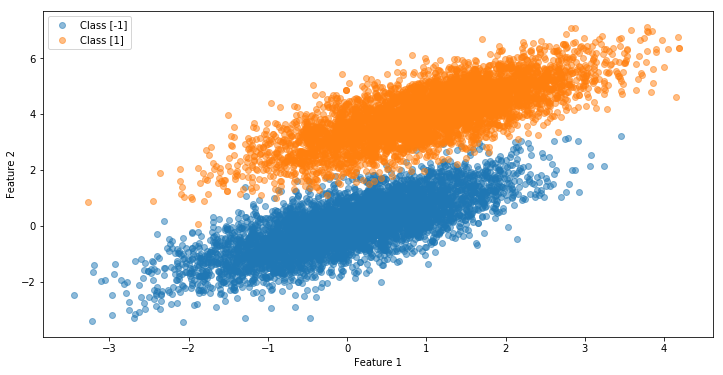

In [568]:
'''
Visualizing the data before implementing the algorithm using scatter plot for 
10000 samples. Each sample will have a color and shape depending on which class (+1 or -1) 
it belongs to.
'''
plt.figure(figsize=(12,6))
plt.scatter(features[labels == -1, 0],features[labels == -1, 1], label='Class [-1]', alpha = 0.5)
plt.scatter(features[labels == 1, 0],features[labels == 1, 1], label='Class [1]', alpha =  0.5)

# plotting the label text
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# mentioning the legend for the plot
plt.legend(loc='best')
plt.show()

In [0]:
def divide_dataset(features, labels):
  '''
  Purpose:  To randomly divide the training and testing dataset as 80% and 20%
  Argument: Passing the features and label
  Returns:  Returns an numpy array for training features, test features, training labels, test labels 
  ''' 
  
  '''
  We are getting random indexes between 0-5000 and 5000-9999 in 2 arrays then we
  shuffle both arrays and then combine them. So the first 5000 numbers will be 
  index between 0-5000 but in different order and same will be for next 5000(5000-9999).
  '''
  x1 = np.arange(5000)
  np.random.shuffle(x1)
  x2 = np.arange(5000,10000)
  np.random.shuffle(x2)
  x = np.hstack((x1,x2))
  features_shuffled, labels_shuffled = features[x], labels[x]


  '''
  We subset features and labels on this index so that their original order will 
  be changed according to this new random indexing. Then we divide this shuffled samples into train and test sets.
  ''' 
  sample = int(0.8 * 5000)                            # gives 4000 as sample value
  features_train1 = features[:sample, :]              # features_train1 holds 4000 value from 0 to 3999 after slicing
  features_train2 = features[5000: 5000+sample, :]    # features_train2 hold 4000 value from 5000 to 8999 after slicing
  features_test1 = features[sample:5000, :]           # features_test1 holds 1000 value from 4000 to 4999 after slicing
  features_test2 = features[5000+sample: , :]         # features_test2 holds 1000 value from 9000 to 9999 after slicing

  labels_train1 =labels[:sample]                      # labels_train1 holds 4000 values from 0 to 3999 after slicing
  labels_train2 =labels[5000: 5000+sample]            # labels_train2 holds 4000 value from 5000 to 8999 after slicing
  labels_test1 =labels[sample:5000]                   # labels_test1 holds 1000 value from 4000 to 4999 after slicing  
  labels_test2 =labels[5000+sample: ]                 # labels_test2 holds 1000 value from 9000 to 9999 after slicing

  train_features = np.vstack((features_train1, features_train2))
  test_features = np.vstack((features_test1, features_test2))

  train_labels = np.hstack((labels_train1, labels_train2))
  test_labels = np.hstack((labels_test1, labels_test2))

  return train_features, test_features, train_labels, test_labels


In [0]:
def sigmoid(X):
  '''
  Purpose:  Computes the sigmoid of X.
  Argument: a numpy array of any size.
  Returns:  Returns sigmoid of X.
  '''
  # f(x) = W.T + b (here T is the transpose)
  # sigmoid (f(x)) = 1 / (1 + e**(-f(x)))
  return 1.0/(1.0 + np.exp(-X))


def pred_values(features, weights, intercept_flag = False): 
  '''
  Purpose:  In order to make predictions for the test labels from the data samples
  Argument: Takes the training features, weights and intercept (with and without intercept considerations) as arguments
  Returns:  a numpy array containing all predictions 
  '''
  
  # To calculate with and without intercept values and adding a column value to the features in case of intercept is True.
  if intercept_flag:
      intercept = np.ones((features.shape[0], 1))
      features = np.hstack((intercept, features))

  # predicting the probability value is greater than 0.5 and for class “-1” less than 0.5    
  pred_prob = sigmoid(features.dot(weights)) 
  pred_value = np.where(pred_prob >= .5, 1, -1) 
  return pred_value


In [0]:
def calc_gradient(features, labels, weights):
  '''
  Purpose:  To computes minimum value of cost function, we are defining gradient 
            function which calculates the derivative of cost function.
  Argument: Takes the training features, weights and labels
  Returns:  return weights after calculation
  ''' 
  # gradient = -(1 / N) * sum((label * features) / (1 + e** (labels*weights*features))
  N = labels.shape[0]
  z = labels * features.dot(weights.T)
  x = 1 / (1 + np.exp(z))
  weights_grad = -1/N * np.dot(x * labels, features)
  return weights_grad # return weights

In [0]:
def cost_function(features, labels, weights):
  '''
  Purpose:  Computes the value of cost for complete training dataset in every 
            iteration (regularization parameter not considered).
  Argument: Takes the training features, weights and labels
  Returns:  Calculated cost is returned.
  '''     
  # cost = (1 / N) * (sum(log(1 + e**((-y*f(x))))) (here y is labels, and f(x) is the dot of features and weights)
  N = labels.size # total value of the training sample i.e, 8000 
  x = np.dot(features,weights)  # x shape is (8000,)
  return (1 / N) * np.sum(np.log(1 + np.exp(-1*np.dot(labels, x)))) # returns the cost value.


In [0]:
def logistic_regression_PB(features, labels, num_steps, learning_rate, intercept_flag = False):
  '''
  Purpose:  To compute the number of iterations , learning rate in order to find the optimal W
            and print cost function and corresponding weights for every 1000th iteration
  Argument: Takes, features, labels, number of iterations , learning rate and intercept as True or False
  Returns:  the resulting weights after the iteration is returned.
  '''
  weights = np.zeros(features.shape[1])
  if intercept_flag:
      intercept = np.ones((features.shape[0], 1))
      features = np.hstack((intercept, features))
  
  weights = np.zeros(features.shape[1])    
  #total_gradient = 0
  for step in range(num_steps):
      weights_grad = calc_gradient(features, labels, weights)
      #updating W based on learning rate and gradient using following equation
      weights -= learning_rate * weights_grad
      
      # for every 1000th iteration.
      if step %1000 == 0:
          #print(cost_function(features, labels, weights), weights)
          print('Weights every 1000th iteration: ', weights)
  return weights

# divide_dataset returns values of training and testing dataset which are stored in train_features, test_features, train_labels, test_labels
train_features, test_features, train_labels, test_labels = divide_dataset(features, labels)

In [574]:
# model without Intercept
print('==========Without Intercept===========')

# function call. passes the values (train_features,) as the parameters logistic_regression_PB function
weights = logistic_regression_PB(train_features, train_labels, num_steps=20000, learning_rate=0.001, intercept_flag = False)

# function call for pred_values functions
preds = pred_values(test_features, weights, intercept_flag=False)

# optimal weights gets printed for the given number of steps and learning rate
print('Weights: ', weights)

# Accuracy calculated
print('Accuracy: ', accuracy_score(test_labels, preds)*100)

# printing confsion matrix
print('Confusion Matrix: ')
cm = confusion_matrix(test_labels, preds)
print(cm)
print()

# model with Intercept
print('==========With Intercept===========')

# function call. passes the values (train_features,) as the parameters logistic_regression_PB function
weights2 = logistic_regression_PB(train_features, train_labels, num_steps=20000, learning_rate=0.001, intercept_flag = True)

# function call for pred_values functions
preds2 = pred_values(test_features, weights2, intercept_flag=True)

# optimal weights gets printed for the given number of steps and learning rate
print('Weights: ', weights2)

# Accuracy calculated
print('Accuracy: ', accuracy_score(test_labels, preds2)*100)

# printing confsion matrix
print('Confusion Matrix: ')
cm = confusion_matrix(test_labels, preds2)
print(cm)


==========Without Intercept===========
Weights every 1000th iteration:  [0.00024733 0.00100334]
Weights every 1000th iteration:  [0.07030975 0.44223073]
Weights every 1000th iteration:  [0.04991756 0.58042573]
Weights every 1000th iteration:  [0.01358287 0.65380188]
Weights every 1000th iteration:  [-0.02703201  0.70070254]
Weights every 1000th iteration:  [-0.06806063  0.73416387]
Weights every 1000th iteration:  [-0.10788885  0.75999328]
Weights every 1000th iteration:  [-0.14580331  0.78114734]
Weights every 1000th iteration:  [-0.18151388  0.79925005]
Weights every 1000th iteration:  [-0.2149457   0.81523789]
Weights every 1000th iteration:  [-0.24613646  0.82967061]
Weights every 1000th iteration:  [-0.27518166  0.84289369]
Weights every 1000th iteration:  [-0.30220424  0.85512762]
Weights every 1000th iteration:  [-0.32733752  0.86651873]
Weights every 1000th iteration:  [-0.35071554  0.87716866]
Weights every 1000th iteration:  [-0.37246792  0.88715169]
Weights every 1000th iter

In [575]:
print('SKlearn Implementation')
from sklearn.metrics import confusion_matrix

## Without Intercept
print('==========Without Intercept===========')

# Parameter fit_intercept is set to False to not consider the value of the intercept
logistic_regression = LogisticRegression(fit_intercept=False, solver = 'lbfgs')

# create an instance of Logistic Regression classifier and fit the data
logistic_regression.fit(train_features, train_labels)

# performs prediction on the test_features
preds = logistic_regression.predict(test_features)

print('Test Accuracy: ', accuracy_score(test_labels, preds)*100)
print('Confusion Matrix :')
print(confusion_matrix(test_labels, preds))
print('Weights : ', logistic_regression.coef_)
print()

## With Intercept
print('==========With Intercept===========')

# fit_intercept = sTrue since we are not considering the value of the intercept now
logistic_regression = LogisticRegression(fit_intercept = True, solver = 'lbfgs')

# create an instance of Logistic Regression classifier and fit the data
logistic_regression.fit(train_features, train_labels)

# performs prediction on the test_features
preds = logistic_regression.predict(test_features)

print('SKlearn Accuracy: ', accuracy_score(test_labels, preds)*100)

print('Confusion Matrix :')
print(confusion_matrix(test_labels, preds))
print('SKlearn Weights : ', logistic_regression.coef_)
print('SKlearn Intercept : ', logistic_regression.intercept_)
print()

SKlearn Implementation
==========Without Intercept===========
Test Accuracy:  75.3
Confusion Matrix :
[[ 506  494]
 [   0 1000]]
Weights :  [[-0.69083188  1.04669738]]

==========With Intercept===========
SKlearn Accuracy:  99.5
Confusion Matrix :
[[997   3]
 [  7 993]]
SKlearn Weights :  [[-3.80065316  6.31191919]]
SKlearn Intercept :  [-10.82772175]

